# Forcing reporting, analysis and processing

Take the raw ERF probablistic ensemble and produce output needed by the DAMIP folks.

1000 ensemble members of the 100,000:
- all forcings
- natural
- well-mixed GHGs (does not include ozone or stratospheric water vapour)
- other anthropogenic

Stratospheric water vapour is not included in WMGHGs, as it appears the intention in DAMIP was to exclude it. From [Gillett et al. (2016)](https://gmd.copernicus.org/articles/9/3685/2016/gmd-9-3685-2016.pdf) (original emphasis):

"**hist-GHG**:  These  historical  greenhouse-gas-only  simulations  resemble  the  historical  simulations  but  instead  are forced by *well-mixed* greenhouse gas changes only, similarly to the CMIP5 historicalGHG experiment. historical, hist-nat,and hist-GHG will allow the attribution of observed climate change to natural, greenhouse gas, and other anthropogenic components.  Models  with  interactive  chemistry  schemes should  either  turn  off  the  chemistry  or  use  a  preindustrial climatology of stratospheric and tropospheric ozone in their radiation  schemes."

Stratospheric water vapour from methane oxidation would only be produced in models with interactive chemistry, therefore the intention appears to be to exclude it from the definition of WMGHG.

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import xarray as xr
import json

In [2]:
ds = xr.load_dataset('../output/ERF_ensemble.nc')

In [3]:
variables = list(ds.keys())

In [5]:
df = pd.read_csv('../output/ERF_best_1750-2023.csv', index_col=0)

In [6]:
#variables

## Non-aggregated statistics

2011, 2019 and 2023

In [7]:
for variable in [
    'CO2', 
    'CH4', 
    'N2O', 
    'aerosol-radiation_interactions', 
    'aerosol-cloud_interactions', 
    'O3',
    'contrails',
    'land_use',
    'BC_on_snow',
    'H2O_stratospheric',
    'solar'
]:
    print(variable, np.percentile(ds[variable].loc[dict(time=2023)], (5, 50, 95)), df.loc[2023, variable])

CO2 [2.01027963 2.28522296 2.55817074] 2.284995284244168
CH4 [0.45119371 0.56423267 0.6773774 ] 0.5647227841332736
N2O [0.19248972 0.22374442 0.25525775] 0.2236853793282699
aerosol-radiation_interactions [-0.49966256 -0.26315575 -0.02592293] -0.2632768432108238
aerosol-cloud_interactions [-1.81042478 -0.92380334 -0.2723894 ] -0.9238033389203684
O3 [0.25596892 0.51227622 0.76682349] 0.5112127908615614
contrails [0.0167524  0.05012964 0.08603824] 0.0500602742060728
land_use [-0.30525776 -0.204138   -0.1012293 ] -0.203772512812091
BC_on_snow [-0.00020584  0.0765584   0.17348919] 0.0773319443918425
H2O_stratospheric [-0.00012756  0.0518161   0.10350096] 0.0519073138274751
solar [0.00048208 0.08224769 0.16310267] 0.0819815979437634


## Aggregated categories

In [8]:
total_best     = np.zeros((274))
natural_best   = np.zeros((274))
aerosol_best   = np.zeros((274))
wmghg_best     = np.zeros((274))
other_ant_best = np.zeros((274))
halogen_best   = np.zeros((274))

for variable in tqdm(variables):
    #print(variable)
    total_best = total_best + df[variable]
    if variable in ['solar', 'volcanic']:
        natural_best = natural_best + df[variable]
    elif variable not in [
        'aerosol-radiation_interactions', 'aerosol-cloud_interactions',
        'O3', 'H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use'
    ]:
        wmghg_best = wmghg_best + df[variable]
    else:
        other_ant_best = other_ant_best + df[variable]
    if variable not in ['solar', 'volcanic', 'aerosol-radiation_interactions', 'aerosol-cloud_interactions',
        'O3', 'H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use', 'CO2', 'CH4', 'N2O']:
        halogen_best = halogen_best + df[variable]
    if variable in ['aerosol-radiation_interactions', 'aerosol-cloud_interactions']:
        aerosol_best = aerosol_best + df[variable]
type(total_best)

  0%|          | 0/61 [00:00<?, ?it/s]

pandas.core.series.Series

In [9]:
df_out = pd.concat(
    [
        total_best, natural_best, total_best-natural_best, wmghg_best, other_ant_best
    ], axis=1
)
df_out.columns = ['total', 'natural', 'anthropogenic', 'wmghgs', 'other_ant']
df_out.to_csv('../output/ERF_best_DAMIP_1750-2023.csv')

In [10]:
total     = np.zeros((274, 100000))
natural   = np.zeros((274, 100000))
aerosol   = np.zeros((274, 100000))
wmghg     = np.zeros((274, 100000))
other_ant = np.zeros((274, 100000))
halogen   = np.zeros((274, 100000))

for variable in tqdm(variables):
    #print(variable)
    total = total + ds[variable]
    if variable in ['solar', 'volcanic']:
        natural = natural + ds[variable]
    elif variable not in [
        'aerosol-radiation_interactions', 'aerosol-cloud_interactions',
        'O3', 'H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use'
    ]:
        wmghg = wmghg + ds[variable]
    else:
        other_ant = other_ant + ds[variable]
    if variable not in ['solar', 'volcanic', 'aerosol-radiation_interactions', 'aerosol-cloud_interactions',
        'O3', 'H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use', 'CO2', 'CH4', 'N2O']:
        halogen = halogen + ds[variable]
    if variable in ['aerosol-radiation_interactions', 'aerosol-cloud_interactions']:
        aerosol = aerosol + ds[variable]

  0%|          | 0/61 [00:00<?, ?it/s]

## Show shape matters

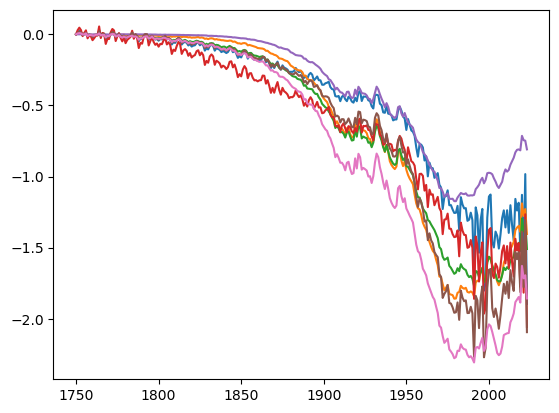

In [11]:
pl.plot(np.arange(1750, 2024), aerosol[:, :7]);

In [12]:
print('halogen', np.percentile(halogen[-1,:], (5, 50, 95)), halogen_best[2023])

halogen [0.33361272 0.41077753 0.4871696 ] 0.410725787766597


In [13]:
# total     = np.zeros((273, 100000))
# natural   = np.zeros((273, 100000))
# aerosol   = np.zeros((273, 100000))
# wmghg     = np.zeros((273, 100000))
# other_ant = np.zeros((273, 100000)) 

print('total:        ', np.percentile(total[-1, :], (5, 50, 95)))
print('anthropogenic:', np.percentile(total[-1, :]-natural[-1, :], (5, 50, 95)))
print('natural:      ', np.percentile(natural[-1, :], (5, 50, 95)))
print('aerosol:      ', np.percentile(aerosol[-1, :], (5, 50, 95)))
print('wmghg:        ', np.percentile(wmghg[-1, :], (5, 50, 95)))
print('other_ant:    ', np.percentile(other_ant[-1, :], (5, 50, 95)))

total:         [2.06252308 3.06592618 3.89887771]
anthropogenic: [1.77555587 2.77568162 3.60443231]
natural:       [0.19292858 0.28948149 0.3861116 ]
aerosol:       [-2.1045236  -1.18926922 -0.49406963]
wmghg:         [3.17420231 3.48321362 3.79181727]
other_ant:     [-1.65388982 -0.70189186  0.0577511 ]


In [14]:
# pick 1000 for export
with open('../data/random_seeds.json') as f:
    seeds = json.load(f)

In [15]:
np.random.seed(seeds[99])
subset = np.random.choice(np.arange(100000), 1000, replace=False)

In [16]:
print('total:        ', np.percentile(total[-1, subset], (5, 50, 95)))
print('anthropogenic:', np.percentile(total[-1, subset]-natural[-1, subset], (5, 50, 95)))
print('natural:      ', np.percentile(natural[-1, subset], (5, 50, 95)))
print('aerosol:      ', np.percentile(aerosol[-1, subset], (5, 50, 95)))
print('wmghg:        ', np.percentile(wmghg[-1, subset], (5, 50, 95)))
print('other_ant:    ', np.percentile(other_ant[-1, subset], (5, 50, 95)))

total:         [2.11146971 3.06974198 3.91135402]
anthropogenic: [1.78382877 2.77662649 3.61660161]
natural:       [0.19192438 0.28659009 0.38220839]
aerosol:       [-2.12779524 -1.18013845 -0.49359477]
wmghg:         [3.18344961 3.48497482 3.80168104]
other_ant:     [-1.65422596 -0.69753844  0.09768527]


In [17]:
xr.Dataset(
    {
        'total': total[:, subset],
        'natural': natural[:, subset],
        'wmghg': wmghg[:, subset],
        'other_ant': other_ant[:, subset]
    }
).to_netcdf('../output/ERF_DAMIP_1000.nc')

In [18]:
ds.close()